In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load the dataset from Parquet file
df = pd.read_parquet('/content/drive/MyDrive/train-00000-of-00001-b64601da56687a05.parquet')

# Shorten the dataset to 300 images and 100 corresponding text entries
shortened_df = df.head(800)

# Save the shortened dataset to a new Parquet file
# shortened_df.to_parquet('shortened_dataset.parquet')

# Display information about the shortened dataset
print("Shape of shortened dataset:", shortened_df.shape)
print("Column names of shortened dataset:", shortened_df.columns)
print("Sample data from shortened dataset:")
print(shortened_df.head())


Shape of shortened dataset: (800, 2)
Column names of shortened dataset: Index(['image', 'text'], dtype='object')
Sample data from shortened dataset:
                                               image  \
0  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
2  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
3  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
4  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   

                                                text  
0  "a logo of coffee shop, take-away coffee cardb...  
1  "a logo of coffee shop, White round background...  
2  "a logo of coffee shop, image of a filled cup ...  
3  "a logo of cafe restaurant bar pizzeria with a...  
4  "a logo of cafe restaurant bar with a circle w...  


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(shortened_df, test_size=0.2, random_state=42)

# Display information about the training and testing sets
print("Shape of training dataset:", train_df.shape)
print("Shape of testing dataset:", test_df.shape)


Shape of training dataset: (640, 2)
Shape of testing dataset: (160, 2)


In [ ]:
!pip install transformers


In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from keras.models import Model
from keras.layers import Input, Concatenate, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation
from keras.optimizers import Adam
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from PIL import Image
import io

# Sample data
# Assuming you have a DataFrame named shortened_df with 'image' and 'text' columns

# Load and preprocess images
def load_images(shortened_df):
    images = []
    for entry in shortened_df['image']:
        image_bytes = entry['bytes']  # Accessing the 'bytes' key in the dictionary
        image = load_and_preprocess_image(image_bytes)
        images.append(image)
    return np.array(images)

def load_and_preprocess_image(image_bytes):
    # Open the image from bytes
    img = Image.open(io.BytesIO(image_bytes))

    # Convert to RGB if image mode is RGBA
    if img.mode == 'RGBA':
        img = img.convert('RGB')

    # Resize images to desired dimensions
    img = img.resize((64, 64))

    # Convert to numpy array and normalize pixel values to range [-1, 1]
    img = np.array(img) / 127.5 - 1.0

    return img

# Assuming 'shortened_df' contains image paths in 'image' column
real_images = load_images(shortened_df)


# Train Word2Vec model
tokenized_data = [word_tokenize(text.lower()) for text in shortened_df['text']]
model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, workers=4)

# Function to get text embedding
def get_text_embedding(text):
    tokens = word_tokenize(text.lower())
    embedding = np.zeros(model.vector_size)
    count = 0
    for token in tokens:
        if token in model.wv:
            embedding += model.wv[token]
            count += 1
    if count != 0:
        embedding /= count
    return embedding

# Get text embeddings for all texts in the dataset
text_embeddings = np.array([get_text_embedding(text) for text in shortened_df['text']])

# Generator
def build_generator(model):

    input_noise = Input(shape=(100,))
    input_embedding = Input(shape=(model.vector_size,))

    x = Concatenate()([input_noise, input_embedding])
    x = Dense(256 * 8 * 8)(x)
    x = Reshape((8, 8, 256))(x)

    x = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(x)

    model = Model(inputs=[input_noise, input_embedding], outputs=x)
    return model

# Discriminator
def build_discriminator(model):
    input_image = Input(shape=(64, 64, 3))
    input_embedding = Input(shape=(model.vector_size,))

    x = Conv2D(64, kernel_size=5, strides=2, padding='same')(input_image)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Flatten()(x)
    x = Concatenate()([x, input_embedding])
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_image, input_embedding], outputs=x)
    return model

# Combined CGAN model
def build_cgan(generator, discriminator, model):
    noise_input = Input(shape=(100,))
    text_input = Input(shape=(model.vector_size,))
    generated_image = generator([noise_input, text_input])
    cgan_output = discriminator([generated_image, text_input])

    model = Model(inputs=[noise_input, text_input], outputs=cgan_output)
    return model

# Instantiate models
generator = build_generator(model)
discriminator = build_discriminator(model)
cgan = build_cgan(generator, discriminator, model)

# Compile the models
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
cgan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# Print model summary
generator.summary()
discriminator.summary()
cgan.summary()


Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_119 (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 input_120 (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 concatenate_41 (Concatenat  (None, 200)                  0         ['input_119[0][0]',           
 e)                                                                  'input_120[0][0]']           
                                                                                                  
 dense_54 (Dense)            (None, 16384)                3293184   ['concatenate_41[0][0]'

In [ ]:
import datetime

In [ ]:
# Training parameters
epochs = 500
batch_size = 32

# Training loop
for epoch in range(epochs):
    # Train discriminator
    # Sample a random batch of real images and text embeddings
    idx = np.random.randint(0, len(real_images), batch_size)
    real_image_batch = real_images[idx]
    text_embedding_batch = text_embeddings[idx]

    # Generate a batch of fake images using random noise and text embeddings
    noise = np.random.randn(batch_size, 100)
    fake_image_batch = generator.predict([noise, text_embedding_batch])

    # Label real and fake images
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train discriminator on real and fake images separately
    real_loss = discriminator.train_on_batch([real_image_batch, text_embedding_batch], real_labels)
    fake_loss = discriminator.train_on_batch([fake_image_batch, text_embedding_batch], fake_labels)

    # Calculate discriminator loss
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)

    # Train generator
    # Generate another batch of fake images
    noise = np.random.randn(batch_size, 100)
    fake_image_batch = generator.predict([noise, text_embedding_batch])

    # Label fake images as real to fool the discriminator
    misleading_labels = np.ones((batch_size, 1))

    # Train generator to generate more realistic images
    generator_loss = cgan.train_on_batch([noise, text_embedding_batch], misleading_labels)

    # Print training progress
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"    Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}")

# After training, you can save the models if desired
generator.save('generator_model.keras')
discriminator.save('discriminator_model.keras')

new_filename = 'cgan_model_{timestamp}.keras'.format(timestamp=datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))  # Or any other unique name
cgan.save(new_filename)

1/1 [==============================] - 0s 192ms/step
Epoch 1/500:
    Discriminator Loss: 0.26872164756059647, Generator Loss: 0.007597815711051226
1/1 [==============================] - 0s 198ms/step
Epoch 2/500:
    Discriminator Loss: 0.0512191466987133, Generator Loss: 0.0008418096113018692
1/1 [==============================] - 0s 197ms/step
Epoch 3/500:
    Discriminator Loss: 0.059292588382959366, Generator Loss: 8.659830200485885e-05
1/1 [==============================] - 0s 182ms/step
Epoch 4/500:
    Discriminator Loss: 0.04175508487969637, Generator Loss: 6.631365977227688e-05
1/1 [==============================] - 0s 187ms/step
Epoch 5/500:
    Discriminator Loss: 0.10199745744466782, Generator Loss: 5.6286844483111054e-05
1/1 [==============================] - 0s 299ms/step
Epoch 6/500:
    Discriminator Loss: 0.08212301135063171, Generator Loss: 2.9927887226222083e-05
1/1 [==============================] - 0s 301ms/step
Epoch 7/500:
    Discriminator Loss: 0.0295856925658

In [ ]:

from keras.models import load_model

1/1 [==============================] - 0s 168ms/step


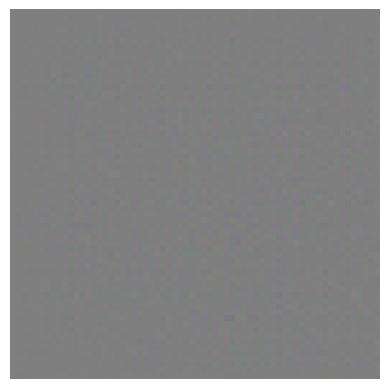

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
generator = load_model('generator_model.keras')
# Function to generate an image based on a prompt
def generate_image_from_prompt(generator, model, prompt_text):
    # Tokenize the prompt text and get its embedding
    prompt_tokens = word_tokenize(prompt_text.lower())
    prompt_embedding = np.zeros(model.vector_size)
    count = 0
    for token in prompt_tokens:
        if token in model.wv:
            prompt_embedding += model.wv[token]
            count += 1
    if count != 0:
        prompt_embedding /= count

    # Generate random noise as input to the generator
    noise_input = np.random.randn(1, 100)

    # Combine the noise input with the prompt embedding
    generated_image = generator.predict([noise_input, prompt_embedding.reshape(1, -1)])

    # Denormalize the generated image
    generated_image = (generated_image + 1) * 127.5
    generated_image = generated_image.astype(np.uint8)

    # Visualize the generated image
    generated_image = Image.fromarray(generated_image[0])
    plt.imshow(generated_image)
    plt.axis('off')
    plt.show()

# Example prompt
prompt_text = "logo of a coffee"

# Generate an image based on the prompt
generate_image_from_prompt(generator, model, prompt_text)


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


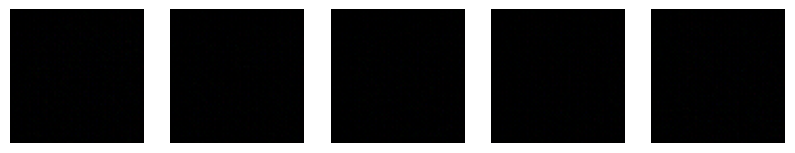

In [ ]:
# Function to display generated images
def display_generated_images(generator, prompt_embedding, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        # Generate random noise input
        noise_input = np.random.randn(1, 100)
        # Generate image based on the prompt
        generated_image = generator.predict([noise_input, np.expand_dims(prompt_embedding, axis=0)])
        # Plot the generated image
        plt.subplot(1, num_images, i+1)
        plt.imshow(generated_image[0])
        plt.axis('off')
    plt.show()
generator = load_model('generator_model.keras')
# Display generated images for a specific text prompt
text_prompt = "yellow is green"
prompt_embedding = get_text_embedding(text_prompt)
display_generated_images(generator, prompt_embedding)

# Evaluation using quantitative metrics (e.g., FID, IS) can be implemented here

# Fine-tuning based on evaluation results
# Modify hyperparameters, network architectures, or training procedures as needed


In [ ]:
# Assuming 'shortened_df' contains image paths in 'image' column
real_images = load_images(shortened_df)


# Convert the list of images to a numpy array
real_images = np.array(real_images)

In [ ]:
from sklearn.metrics import mean_squared_error

def calculate_mse(real_images, generated_image):
    # Flatten the real images to 2D array
    real_images_flat = real_images.reshape(len(real_images), -1)

    # Flatten the generated image to 2D array
    generated_image_flat = generated_image.reshape(1, -1)

    # Calculate MSE
    mse = mean_squared_error(real_images_flat, np.repeat(generated_image_flat, len(real_images_flat), axis=0))

    return mse

# Evaluate MSE
mse_score = calculate_mse(real_images, generated_image)
print("Mean Squared Error (MSE):", mse_score)


1/1 [==============================] - 0s 186ms/step


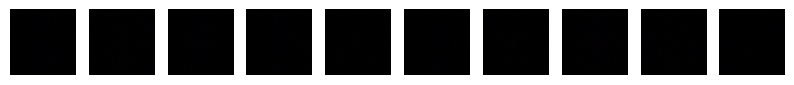

In [ ]:
num_images = 10  # Number of images to generate
noise = np.random.normal(0, 1, (num_images, 100))
species_list = ["coffee", "soft-green", "horse", "bird", "fish"]
random_texts = np.random.choice(species_list, num_images)

# Get text embeddings for random texts
random_text_embeddings = np.array([get_text_embedding(text) for text in random_texts])

# Instantiate generator model
generator = build_generator(model)

# Generate images using the generator
generated_images = generator.predict([noise, random_text_embeddings])
import matplotlib.pyplot as plt

def display_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
    for i, image in enumerate(images):
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.show()

# Display the generated images
display_images(generated_images)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

i am trying to see the embeddings from word2vec


In [ ]:
# Access the embedding matrix
embedding_matrix = model.wv.vectors

# Get the vocabulary
vocabulary = model.wv.index_to_key

# Print the embedding vector for each word in the vocabulary
for word in vocabulary:
    word_embedding = embedding_matrix[model.wv.key_to_index[word]]
    print(f"Embedding for '{word}': {word_embedding}")


Streaming output truncated to the last 5000 lines.
 -1.51470797e-02 -5.88264456e-03 -1.19761620e-02  9.26319510e-03
 -7.97074754e-03  7.14189420e-03  1.36715556e-02  5.97926369e-03
  5.42397471e-03 -2.87127506e-04  1.15876440e-02  9.70784016e-03
  8.70145950e-03  1.92474702e-03  1.21314190e-02 -6.47892896e-03
 -8.66970455e-04  6.58239843e-03  2.16127397e-03  2.17201724e-03]
Embedding for 'design': [-1.8484119e-03  1.1411643e-02  5.7828515e-03  1.0151200e-02
  1.0305532e-02 -1.4676759e-02  6.9173765e-03  1.6295537e-02
 -5.5873413e-03 -1.2870260e-03  1.3856480e-03 -3.1190430e-05
 -7.5544431e-03  1.5939331e-04 -5.3884764e-03 -1.0998630e-02
  5.2362159e-03  6.5757567e-04 -1.0780319e-02 -1.9892715e-02
  1.3300235e-02  4.7703916e-03  2.3193187e-03  4.2017819e-03
  8.6219236e-03 -6.6345963e-03  5.1104522e-04 -7.5477017e-03
 -1.8317590e-04 -5.4916637e-03 -2.9811994e-03  3.6291271e-03
 -5.5578584e-03 -1.0582729e-02  2.4740372e-03 -2.5313145e-03
  5.5859145e-03  7.5797847e-04 -8.8440217e-03 -1.9

trying to see how images has been preprocessed

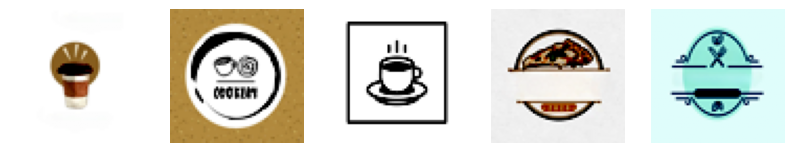

In [ ]:
import matplotlib.pyplot as plt

# Load and preprocess five images
preprocessed_images = []
for i in range(5):
    image_bytes = shortened_df['image'][i]['bytes']
    preprocessed_image = load_and_preprocess_image(image_bytes)
    preprocessed_images.append(preprocessed_image)

# Display the preprocessed images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(preprocessed_images[i])
    plt.axis('off')
plt.show()


what happens when i change the no of channel from 4 to 3

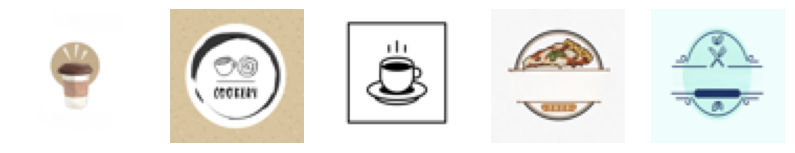

In [ ]:





# Load and preprocess five images with mode conversion
converted_images = []
for i in range(5):
    image_bytes = shortened_df['image'][i]['bytes']
    img = Image.open(io.BytesIO(image_bytes))
    img = img.convert('RGB')  # Convert mode to RGB
    img = img.resize((64, 64))
    converted_images.append(np.array(img) / 255.0)

# Display the converted images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(converted_images[i])
    plt.axis('off')
plt.show()


In [ ]:
# that shows not a great change, TAB Q NAHI GENERATE KAR RAHA

In [ ]:
# try 3

In [ ]:
# from keras.models import Model
# from keras.layers import Input, Concatenate, Dense, Reshape, Flatten
# from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation
# from keras.optimizers import Adam
# from gensim.models import Word2Vec
# from nltk.tokenize import word_tokenize
# import numpy as np
# import pandas as pd
# from PIL import Image
# import io

# # Sample data
# # Assuming you have a DataFrame named shortened_df with 'image' and 'text' columns

# # Load and preprocess images
# def load_images(shortened_df):
#     images = []
#     for entry in shortened_df['image']:
#         image_bytes = entry['bytes']  # Accessing the 'bytes' key in the dictionary
#         image = load_and_preprocess_image(image_bytes)
#         images.append(image)
#     return np.array(images)

# def load_and_preprocess_image(image_bytes):
#     # Open the image from bytes
#     img = Image.open(io.BytesIO(image_bytes))

#     # Convert to RGB if image mode is RGBA
#     if img.mode == 'RGBA':
#         img = img.convert('RGB')

#     # Resize images to desired dimensions
#     img = img.resize((128, 128))

#     # Convert to numpy array and normalize pixel values to range [-1, 1]
#     img = np.array(img) / 127.5 - 1.0

#     return img

# # Assuming 'shortened_df' contains image paths in 'image' column
# # real_images = load_images(shortened_df)  # Commented out for now as 'shortened_df' is not defined


# # Train Word2Vec model
# tokenized_data = [word_tokenize(text.lower()) for text in shortened_df['text']]
# model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, workers=4)

# # Function to get text embedding
# def get_text_embedding(text):
#     tokens = word_tokenize(text.lower())
#     embedding = np.zeros(model.vector_size)
#     count = 0
#     for token in tokens:
#         if token in model.wv:
#             embedding += model.wv[token]
#             count += 1
#     if count != 0:
#         embedding /= count
#     return embedding

# # Get text embeddings for all texts in the dataset
# text_embeddings = np.array([get_text_embedding(text) for text in shortened_df['text']])

# # Generator
# def build_generator(model):
#     input_noise = Input(shape=(100,))
#     input_embedding = Input(shape=(model.vector_size,))

#     embedded_input = Dense(8 * 8 * 32)(input_embedding)
#     embedded_input = Reshape((8, 8, 32))(embedded_input)

#     x = Dense(256 * 8 * 8)(input_noise)
#     x = Reshape((8, 8, 256))(x)

#     x = Concatenate()([x, embedded_input])

#     x = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = Conv2DTranspose(32, kernel_size=5, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     # Output layer with 3 channels for RGB image
#     output_image = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(x)

#     generator_model = Model(inputs=[input_noise, input_embedding], outputs=output_image)
#     return generator_model

# # Discriminator
# def build_discriminator(model):
#     input_image = Input(shape=(128, 128, 3))  # Input shape for images
#     input_embedding = Input(shape=(model.vector_size,))  # Input shape for text embeddings

#     x = Conv2D(64, kernel_size=5, strides=2, padding='same')(input_image)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     # Additional convolutional layer
#     x = Conv2D(256, kernel_size=5, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = Flatten()(x)
#     x = Concatenate()([x, input_embedding])
#     x = Dense(1, activation='sigmoid')(x)

#     discriminator_model = Model(inputs=[input_image, input_embedding], outputs=x)
#     return discriminator_model


# # Combined CGAN model
# def build_cgan(generator, discriminator, model):
#     noise_input = Input(shape=(100,))
#     text_input = Input(shape=(model.vector_size,))
#     generated_image = generator([noise_input, text_input])
#     cgan_output = discriminator([generated_image, text_input])

#     cgan_model = Model(inputs=[noise_input, text_input], outputs=cgan_output)
#     return cgan_model



# # Instantiate models
# generator = build_generator(model)
# discriminator = build_discriminator(model)
# cgan = build_cgan(generator, discriminator, model)

# # Compile the models
# discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
# cgan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# # Print model summary
# generator.summary()
# discriminator.summary()
# cgan.summary()


Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_111 (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 input_112 (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 dense_50 (Dense)            (None, 16384)                1654784   ['input_111[0][0]']           
                                                                                                  
 dense_49 (Dense)            (None, 2048)                 206848    ['input_112[0][0]']           
                                                                                           